# Описательная статистика параметров крупных пожаров

In [4]:
# Подключение модулей
import pandas as pd, numpy as np
import pyodbc as sqlMS # связь с Access
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [160]:
# Создание связи с БД "Пожары"
connStr = (r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};" r"DBQ=C:\FR\FR.accdb;")
conn = sqlMS.connect(connStr) # создать соединение с БД
cursor = conn.cursor()

def BigFr(Yr):  # Запрос к БД Access
    strSQL = f'''
    SELECT FR{Yr}.F0, 60*([F159]-[F63])+([F160]-[F64])+1440*([F71]-[F5]) AS Tm, [F83]+[F84]+[F85]+[F86]+[F87] AS Tex, [F91]+[F92]+[F93] AS Stv
    FROM т27F109_110_РТП INNER JOIN (т08F12_Объекты INNER JOIN FR{Yr} ON т08F12_Объекты.F12 = FR{Yr}.F12) ON т27F109_110_РТП.F109 = FR{Yr}.F110
    WHERE (((60*([F159]-[F63])+([F160]-[F64])+1440*([F71]-[F5]))>9) AND (([F83]+[F84]+[F85]+[F86]+[F87])>0) AND (([F91]+[F92]+[F93])>0) AND (([F43]+[F44])>1) AND ((FR{Yr}.F161)=1) AND ((FR{Yr}.F99)>0) AND ((т08F12_Объекты.ОбъектТактика)=1 Or (т08F12_Объекты.ОбъектТактика)=2) AND ((FR{Yr}.F4)=0) AND ((т27F109_110_РТП.Статус61)>4));
    '''

    return pd.read_sql(strSQL, conn)

df0 = BigFr(2020)
df1 = BigFr(2021)
df = df0.append(df1, ignore_index=True)  # присоединть df1 к df0 и обновить индексы

#  Закрыть соединение с базой Access
cursor.close()
del cursor
conn.close()  


mask = (df.Tm < 0) 
df.loc[mask, 'Tm'] = df.Tm + 1440

df = df.dropna()  # удалить NaN
df = df.astype(int, errors='ignore')  # преобразовать весь фрейм до целого

df.to_pickle('big_fr.pkl')  # сохранить фрейм в файл pikle


In [201]:
df = pd.read_pickle('big_fr.pkl')
# df.to_excel('Output1.xlsx')  # Сохранить фрейм в файл Excel
df # Выборка

,F0,Tm,Tex,Stv
0,411,87,9,4
1,2271,96,14,3
2,2829,31,18,2
3,3309,72,9,4
4,4157,61,9,3
...,...,...,...,...
1704,1120086,59,15,2
1705,1120112,97,33,12
1706,1120261,27,9,2
1707,1120305,36,10,1


In [125]:
df.describe()  # Описательная статистика

,Tm,Tex,Stv
count,1709.000000,1709.000000,1709.000000
mean,202.712697,8.606202,4.241662
std,307.514058,4.929478,4.284742
min,10.000000,1.000000,1.000000
25%,54.000000,5.000000,2.000000
50%,114.000000,8.000000,3.000000
75%,235.000000,11.000000,6.000000
max,6260.000000,102.000000,93.000000


# #  Частоты распределений показателей

In [126]:
df.Tm.value_counts().sort_index(ascending=True)[:35]  # Интервал времени занятости

10     5
11     5
12     4
13     7
14     5
15     6
16     8
17    10
18     5
19    11
20    10
21    17
22    11
23     8
24     8
25     8
26     8
27     8
28    11
29    15
30    10
31     9
32    18
33    11
34     9
35     9
36    12
37    15
38     8
39    10
40    16
41    11
42     8
43    15
44    13
Name: Tm, dtype: int64

In [136]:
df.Tex.value_counts().sort_index(ascending=True)  #  Количество техники, привлекаемой на пожар

1        1
2        9
3       54
4      162
5      186
6      184
7      182
8      150
9      111
10      91
11      81
12      68
13      47
14      45
15      38
16      20
17      17
18      13
19       9
20      12
21       3
22       2
23       1
24       1
25       1
26       1
29       1
30       1
31       1
32       1
33       1
40       1
102      1
Name: Tex, dtype: int64

In [163]:
df.Stv.value_counts().sort_index(ascending=True)  #  Количество стволов, подаваемых на тушение пожара 

1     316
2     306
3     233
4     186
5     124
6     106
7      65
8      50
9      28
10     23
11     14
12     12
13      8
14      3
15      6
16      1
17      2
18      1
19      2
20      2
21      2
22      1
23      1
32      1
33      1
57      1
93      1
Name: Stv, dtype: int64

# #  Оценка ядерной плотности распределений

C:\Users\Arlen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


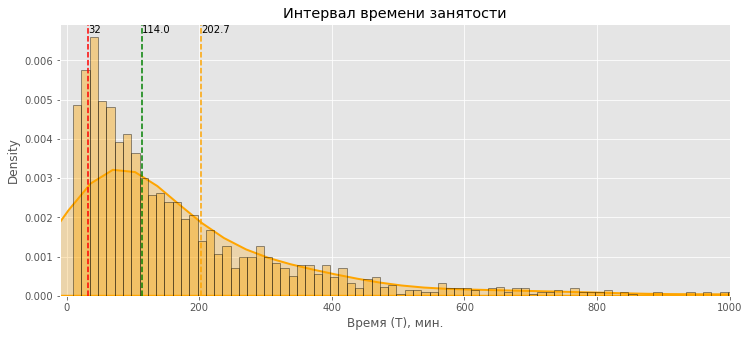

In [133]:
matplotlib.style.use('ggplot')
DD = df.Tm  # Интервал времени занятости
fig, ax = plt.subplots(figsize=(12,5))

ax.set(xlim = [-10, 1000],  title = 'Интервал времени занятости')

sns.distplot(DD, hist=True, kde = True, kde_kws = {'shade' : True , 'linewidth' : 2 }, label = 'Normal', color = 'orange',
            bins=500, axlabel='Время (Т), мин.', hist_kws = {'edgecolor': 'black', 'linewidth': 1})

# Вертикальные линии и подписи
def vline(x, y, col):
    plt.axvline(x, color=col, linestyle='dashed', linewidth=1.5) 
    plt.text(x, y, round(x,1), color='black')
    
yv = 0.0067 # положение подписи по оси Y 
vline(DD.mean(), yv, 'orange')
vline(DD.median(), yv, 'green')
vline(DD.mode()[0], yv, 'red')

fig.savefig('img/img-Tm', dpi=300, bbox_inches = 'tight')

C:\Users\Arlen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


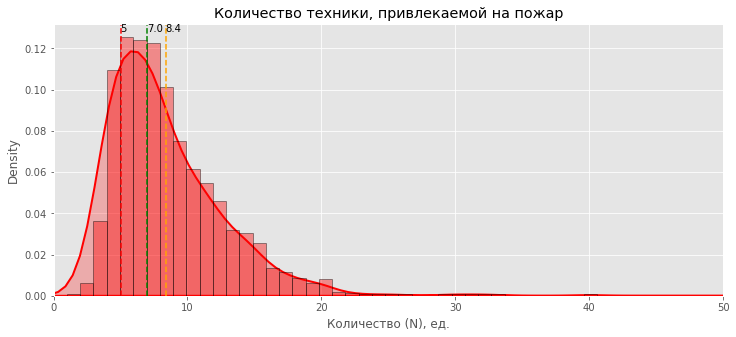

In [72]:
DD = df.Tex  # Количество техники, привлекаемой на пожар
fig, ax = plt.subplots(figsize=(12,5))

ax.set(xlim = [0, 50], title = 'Количество техники, привлекаемой на пожар')

sns.distplot(DD, hist=True, kde = True, kde_kws = {'shade' : True , 'linewidth' : 2 }, label = 'Normal', color = 'red',
            bins=102, axlabel='Количество (N), ед.', hist_kws = {'edgecolor': 'black', 'linewidth': 1})

# Вертикальные линии и подписи
def vline(x, y, col):
    plt.axvline(x, color=col, linestyle='dashed', linewidth=1.5) 
    plt.text(x, y, round(x,1), color='black')
    
yv = 0.128 # положение подписи по оси Y 
vline(DD.mean(), yv, 'orange')
vline(DD.median(), yv, 'green')
vline(DD.mode()[0], yv, 'red')

fig.savefig('img/img-Tex', dpi=300, bbox_inches = 'tight')

C:\Users\Arlen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


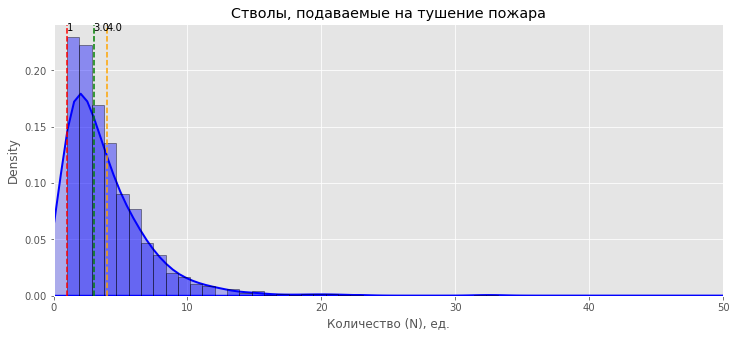

In [118]:
DD = df.Stv  # Стволы, подаваемые на тушение пожара
fig, ax = plt.subplots(figsize=(12,5))

ax.set(xlim = [0, 50], title = 'Стволы, подаваемые на тушение пожара')

sns.distplot(DD, hist=True, kde = True, kde_kws = {'shade' : True , 'linewidth' : 2 }, label = 'Normal1', color = 'blue',
            bins=100, axlabel='Количество (N), ед.', hist_kws = {'edgecolor': 'black', 'linewidth': 1})

# Вертикальные линии и подписи
def vline(x, y, col):
    plt.axvline(x, color=col, linestyle='dashed', linewidth=1.5) 
    plt.text(x, y, round(x,1), color='black')
    
yv = 0.235 # положение подписи по оси Y 
vline(DD.mean(), yv, 'orange')
vline(DD.median(), yv, 'green')
vline(DD.mode()[0], yv, 'red') 

fig.savefig('img/img-Stv', dpi=300, bbox_inches = 'tight')

# # Оценка разброса значений показателей

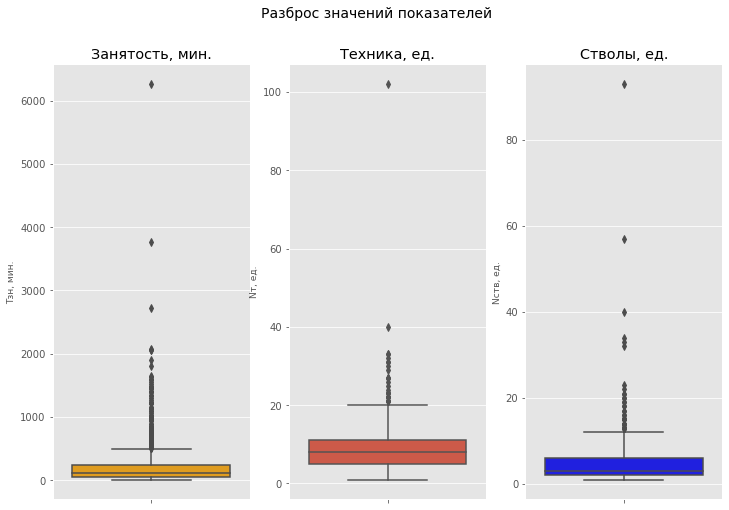

In [134]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(12,8))
fig.suptitle('Разброс значений показателей', size=14)
axes[0].set_title('Занятость, мин.')
axes[1].set_title('Техника, ед.')
axes[2].set_title('Стволы, ед.')

sns.boxplot(ax=axes[0], y=df.Tm, color = 'orange')
axes[0].set_ylabel('Tзн, мин.', size=9)
sns.boxplot(ax=axes[1], y=df.Tex)
axes[1].set_ylabel('Nт, ед.', size=9)
sns.boxplot(ax=axes[2], y=df.Stv, color='blue')
axes[2].set_ylabel('Nств, ед.', size=9)

fig.savefig('img/img-Boxplot', dpi=300, bbox_inches = 'tight')

<AxesSubplot:xlabel='Tзн, ед.', ylabel='Nт, ед.'>

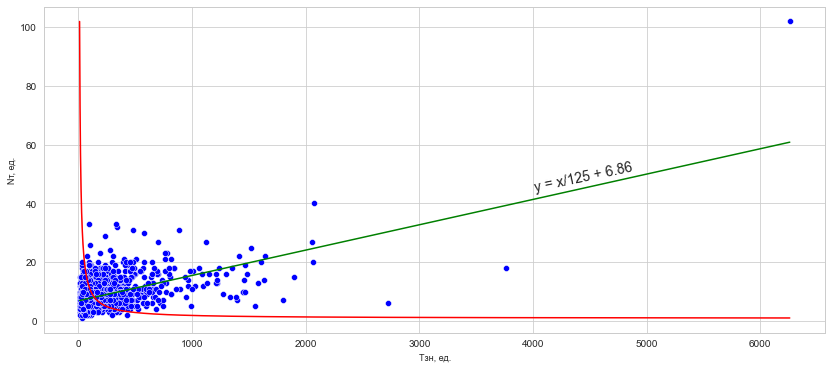

In [248]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,6))
ax.set_ylabel('Nт, ед.', size=9)
ax.set_xlabel('Tзн, ед.', size=9)
sns.scatterplot(data=df, x='Tm', y='Tex', color = 'blue')
# Линия тренда
x, y = df.Tm, df.Tex
fit = np.polyfit(x, y, deg=1)
fit_function = np.poly1d(fit)
plt.text(4000, 44, 'y = x/125 + 6.86', size=14, rotation=12)
sns.lineplot(x=x,y=fit_function(x), color = 'green')
# Гипербола
y = 1011.6/x+0.84
sns.lineplot(x=x,y=y, color = 'red')

<AxesSubplot:xlabel='Tзн, ед.', ylabel='Nств, ед.'>

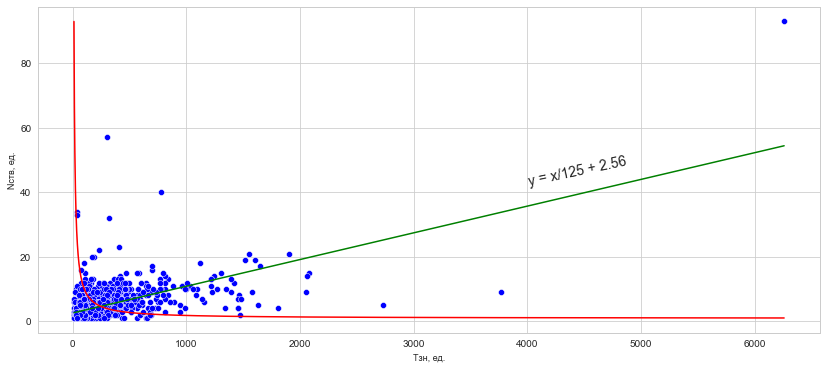

In [247]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_ylabel('Nств, ед.', size=9)
ax.set_xlabel('Tзн, ед.', size=9)
sns.scatterplot(data=df, x='Tm', y='Stv', color = 'blue')
# Линия тренда
x, y = df.Tm, df.Stv
fit = np.polyfit(x, y, deg=1)
fit_function = np.poly1d(fit)
plt.text(4000, 42, 'y = x/125 + 2.56', size=14, rotation=12)
sns.lineplot(x=x,y=fit_function(x), color = 'green')
# Гипербола
y = 921.47/x+0.85
sns.lineplot(x=x,y=y, color = 'red')

<AxesSubplot:xlabel='Nт, ед.', ylabel='Nств, ед.'>

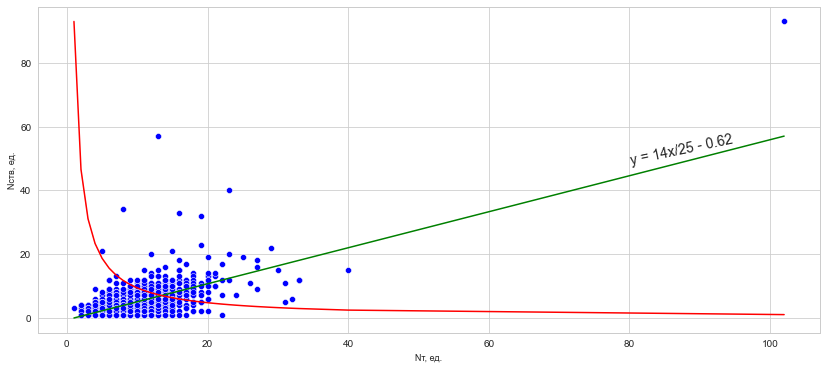

In [246]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_ylabel('Nств, ед.', size=9)
ax.set_xlabel('Nт, ед.', size=9)
sns.scatterplot(data=df, x='Tex', y='Stv', color = 'blue')
# Линия тренда
x, y = df.Tex, df.Stv
fit = np.polyfit(x, y, deg=1)
fit_function = np.poly1d(fit)
plt.text(80, 48, 'y = 14x/25 - 0.62', size=14, rotation=12)
sns.lineplot(x=x,y=fit_function(x), color = 'green')
# Гипербола
y = 92.91/x+0.09
sns.lineplot(x=x,y=y, color = 'red')

In [249]:
df  # Исходный фрейм

,F0,Tm,Tex,Stv
0,411,87,9,4
1,2271,96,14,3
2,2829,31,18,2
3,3309,72,9,4
4,4157,61,9,3
...,...,...,...,...
1704,1120086,59,15,2
1705,1120112,97,33,12
1706,1120261,27,9,2
1707,1120305,36,10,1


In [297]:
df = pd.read_pickle('big_fr.pkl')
BigFire_lim = 100  #  Предполагаемое количество крупных пожаров (для РФ ~ 100, для отдельного региона ~ 10)
i=0
df['Cond'] = 1

print('Количество крупных пожаров на каждом i-ом шаге вычислений:')
while df.Cond.sum() > BigFire_lim:
    i += 1  # шаг смещения границы крупных пожаров
    df.Cond = 0  # обнуление меток
    
    # новое значение ординаты для параметров пожара
    df['Tm_Tex'] = df.Tex-i*0.008 
    df['Tm_Stv'] = df.Stv-i*0.008 
    df['Tex_Stv'] = df.Stv-i*0.56 

    # новое значение ординаты для границы крупных пожаров
    df['Tm_Tex_lim'] = 1011.6/(df.Tm-i)+0.84
    df['Tm_Stv_lim'] = 921.47/(df.Tm-i)+0.85
    df['Tex_Stv_lim'] = 92.91/(df.Tex-i)+0.09

    # метка для крупных пожаров df.Cond == 1
    mask = (df.Tm_Tex > df.Tm_Tex_lim) & (df.Tm_Stv > df.Tm_Stv_lim)  & (df.Tex_Stv > df.Tex_Stv_lim)
    df.loc[mask, 'Cond'] = 1
    print(df.Cond.sum(), end=',')  # количество крупных пожаров на каждом i-ом шаге вычислений
    
BigFire_List = df.F0[df.Cond == 1].tolist()  # Список индексов крупных пожаров
print()
print('Количество крупных пожаров -', df.Cond.sum())
print('Список индексов крупных пожаров:', BigFire_List)
print()
df[df.Cond == 1]


Количество крупных пожаров на каждом i-ом шаге вычислений:
141,112,91,
Количество крупных пожаров - 91
Список индексов крупных пожаров: [8252, 28053, 50248, 64308, 68421, 70008, 73494, 88143, 98276, 112474, 112953, 113154, 113955, 114141, 129604, 132962, 133645, 172884, 187019, 193155, 193290, 196012, 199450, 252929, 266497, 289662, 297297, 302181, 311970, 315114, 315609, 316721, 320934, 326456, 330842, 336642, 363231, 364868, 382073, 384677, 386365, 387724, 396816, 776640, 780004, 784274, 826961, 828739, 832676, 861552, 864291, 868655, 884117, 884506, 911656, 914444, 917354, 925074, 931535, 934247, 936616, 936617, 941135, 948996, 954178, 954649, 959203, 961537, 962909, 963298, 976963, 996416, 997855, 998982, 1000617, 1001582, 1019876, 1023741, 1034536, 1049090, 1086681, 1089767, 1091658, 1093170, 1113497, 1113498, 1114221, 1114534, 1115842, 1116463, 1120112]



,F0,Tm,Tex,Stv,Cond,Tm_Tex,Tm_Stv,Tex_Stv,Tm_Tex_lim,Tm_Stv_lim,Tex_Stv_lim
8,8252,1123,27,18,1,26.976,17.976,16.32,1.743214,1.672741,3.961250
22,28053,1241,18,14,1,17.976,13.976,12.32,1.657124,1.594321,6.284000
38,50248,1415,22,12,1,21.976,11.976,10.32,1.556431,1.502599,4.980000
62,64308,336,32,6,1,31.976,5.976,4.32,3.877838,3.617177,3.293793
83,68421,489,18,9,1,17.976,8.976,7.32,2.921481,2.746029,6.284000
...,...,...,...,...,...,...,...,...,...,...,...
1608,1114221,1301,16,15,1,15.976,14.976,13.32,1.619353,1.559915,7.236923
1613,1114534,231,29,22,1,28.976,21.976,20.32,5.276842,4.891535,3.663462
1638,1115842,765,23,12,1,22.976,11.976,10.32,2.167559,2.059278,4.735500
1648,1116463,158,16,13,1,15.976,12.976,11.32,7.366452,6.794968,7.236923
